# System Identification with NeuroMANCER: Duffing Parameter

This is an interactive notebook based on `duffing_parameter.py`. We demonstrate how the NeuroMANCER toolbox can be used for parameter estimation of the [Duffing ODE system](https://en.wikipedia.org/wiki/Duffing_equation) using stochastic gradient descent (SGD).

## NeuroMANCER and Dependencies

### Install (Colab only)

Skip this step when running locally.

In [ ]:
!pip install pyts torchdiffeq mlflow plum-dispatch
!pip install git+https://github.com/pnnl/slim.git@master#egg=slim
!pip install git+https://github.com/pnnl/psl.git@master#egg=psl
!pip install git+https://github.com/pnnl/neuromancer.git@master#egg=neuromancer

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/pnnl/slim.git (to revision master) to /tmp/pip-install-p0xsj2jp/slim_b1cf442d6c054481bbad710ed87cb3af
  Running command git clone --filter=blob:none --quiet https://github.com/pnnl/slim.git /tmp/pip-install-p0xsj2jp/slim_b1cf442d6c054481bbad710ed87cb3af
  Resolved https://github.com/pnnl/slim.git to commit 3fbe3a7819e1eb6e1d794d98de85e0c2fa7b6dcc
  Preparing metadata (setup.py) ... done
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/pnnl/psl.git (to revision master) to /tmp/pip-install-d48vbajv/psl_80cbf846d64d4289a577c3d76af6c25a
  Running command git clone --filter=blob:none --quiet https://github.com/pnnl/psl.git /tmp/pip-install-d48vbajv/psl_80cbf846d64d4289a577c3d76af6c25a
  Res

### Import

In [ ]:
from IPython.display import Image
import matplotlib.pyplot as plt
import numpy as np

import torch
import slim
import psl

In [ ]:
from neuromancer import blocks, estimators, dynamics, integrators, ode
from neuromancer.interpolation import LinInterp_Offline
from neuromancer.trainer import Trainer
from neuromancer.problem import Problem
from neuromancer.loggers import BasicLogger
from neuromancer.constraint import variable
from neuromancer.dataset import get_sequence_dataloaders
from neuromancer.loss import PenaltyLoss
import neuromancer.simulator as sim

# Dataset

In [ ]:
torch.manual_seed(0)
device = "cpu"

Load the ground truth dataset by simulating the ODE system.

In [ ]:
system = psl.systems['Duffing']
ts = 0.01
nsim = 1000
modelSystem = system(ts=ts, nsim=nsim)
raw = modelSystem.simulate()

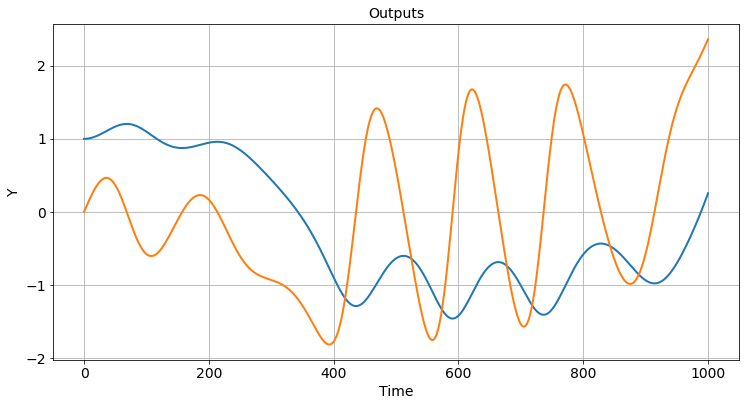

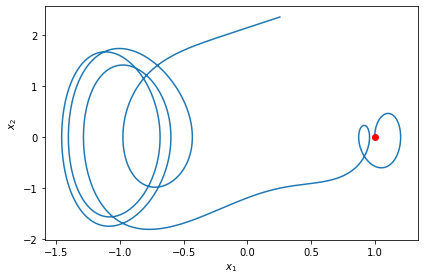

In [ ]:
psl.plot.pltOL(Y=raw['Y'])
fig = plt.gcf()
fig.set_size_inches((10,5))
psl.plot.pltPhase(X=raw['Y'])

Interpolate time for the ODE integrator of non-autonomous system

In [ ]:
t = (np.arange(nsim+1)*ts).reshape(-1, 1)
raw['Time'] = t
t = torch.from_numpy(t)
interp_u = LinInterp_Offline(t, t)

Create sequence dataloaders with given prediction horizon.

In [ ]:
nsteps = 2
nstep_data, loop_data, dims = get_sequence_dataloaders(raw, nsteps,
                                moving_horizon=True)
train_data, dev_data, test_data = nstep_data    # (nstep, # batches, sys dim)
train_loop, dev_loop, test_loop = loop_data

# check for dataset keys
train_data.dataset.get_full_batch().keys()

dict_keys(['Xp', 'Yp', 'Timep', 'Xf', 'Yf', 'Timef', 'name'])

# System Model

## State Estimator

In [ ]:
# Fully observable state estimator as identity mapping
nx = dims['X'][1]
estim = estimators.FullyObservable(
    {**train_data.dataset.dims, "x0": (nx,)},
    linear_map=slim.maps['identity'],
    input_keys=["Yp"])
# test forward pass of the estimator
estim(train_data.dataset.get_full_batch())

{'x0_fully_observable': tensor([[ 1.0000,  0.0000],
         [ 1.0001,  0.0200],
         [ 1.0004,  0.0399],
         [ 1.0009,  0.0598],
         [ 1.0016,  0.0796],
         [ 1.0025,  0.0992],
         [ 1.0036,  0.1187],
         [ 1.0049,  0.1380],
         [ 1.0063,  0.1570],
         [ 1.0080,  0.1757],
         [ 1.0099,  0.1942],
         [ 1.0119,  0.2122],
         [ 1.0141,  0.2300],
         [ 1.0165,  0.2473],
         [ 1.0190,  0.2642],
         [ 1.0218,  0.2806],
         [ 1.0246,  0.2965],
         [ 1.0277,  0.3119],
         [ 1.0309,  0.3267],
         [ 1.0342,  0.3409],
         [ 1.0377,  0.3545],
         [ 1.0413,  0.3675],
         [ 1.0450,  0.3797],
         [ 1.0489,  0.3913],
         [ 1.0529,  0.4021],
         [ 1.0569,  0.4122],
         [ 1.0611,  0.4215],
         [ 1.0654,  0.4300],
         [ 1.0697,  0.4376],
         [ 1.0741,  0.4444],
         [ 1.0786,  0.4504],
         [ 1.0831,  0.4554],
         [ 1.0877,  0.4595],
         [ 1.0923,  

## Dynamics Model

In [ ]:
# use either ODE or MLP RHS (uncomment)
duffing_sys = ode.DuffingParam()  # ODE RHS
# duffing_sys = blocks.MLP(insize=nx+1, outsize=nx, hsizes=[32, 32])  # MLP RHS

In [ ]:
# ODE integrator
fx_int = integrators.RK4(duffing_sys, interp_u=interp_u, h=modelSystem.ts)
fy = slim.maps['identity'](nx, nx)  # output model

# component class mapping symbolic variables
dynamics_model = dynamics.ODENonAuto(fx_int, fy, 
input_key_map={"x0": estim.output_keys[0], 'Time': 'Timef'},
               extra_inputs=['Time'], name='dynamics', online_flag=False)

# Variables

In [ ]:
# symbolic NeuroMANCER variables
yhat = variable(dynamics_model.output_keys[2])
y = variable("Yf")

# composite variables
yFD = (y[:, 1:, :] - y[:, :-1, :])
yhatFD = (yhat[:, 1:, :] - yhat[:, :-1, :])

# Objectives

In [ ]:
fd_loss = 2.0*((yFD == yhatFD)^2)
fd_loss.name = 'FD_loss'

reference_loss = ((yhat == y)^2)
reference_loss.name = "ref_loss"

# NeuroMANCER Differentiable Problem

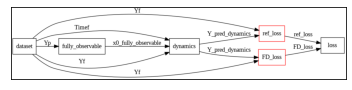

In [ ]:
objectives = [reference_loss, fd_loss]
constraints = []
components = [estim, dynamics_model]

# create optimization loss
loss = PenaltyLoss(objectives, constraints)
# construct parametric optimization problem
problem = Problem(components, loss)
problem = problem.to(device)
# plot computational graph
problem.plot_graph()

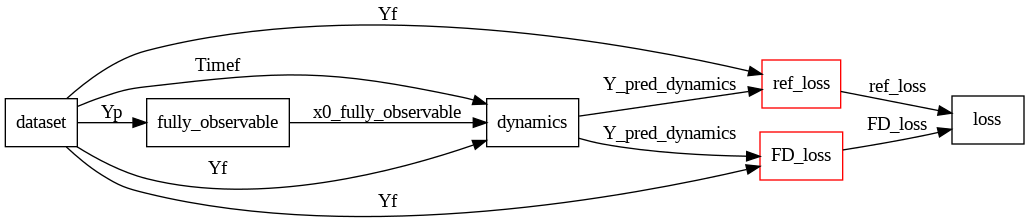

In [ ]:
Image('problem_graph.png')

# Train

In [ ]:
optimizer = torch.optim.Adam(problem.parameters(), lr=0.1)
logger = BasicLogger(args=None, savedir='test', verbosity=1,
                     stdout="nstep_dev_"+reference_loss.output_keys[0])
trainer = Trainer(
    problem,
    train_data,
    dev_data,
    test_data,
    optimizer,
    patience=20,
    warmup=100,
    epochs=200,
    eval_metric="nstep_dev_"+reference_loss.output_keys[0],
    train_metric="nstep_train_loss",
    dev_metric="nstep_dev_loss",
    test_metric="nstep_test_loss",
    logger=logger,
    device=device,
)

None
Number of parameters: 1


In [ ]:
best_model = trainer.train()
best_outputs = trainer.test(best_model)

epoch: 0	nstep_dev_Y_pred_dynamics_eq_Yf: 0.00089	eltime:  0.09940
epoch: 1	nstep_dev_Y_pred_dynamics_eq_Yf: 0.00005	eltime:  0.15009
epoch: 2	nstep_dev_Y_pred_dynamics_eq_Yf: 0.00011	eltime:  0.20108
epoch: 3	nstep_dev_Y_pred_dynamics_eq_Yf: 0.00023	eltime:  0.25388
epoch: 4	nstep_dev_Y_pred_dynamics_eq_Yf: 0.00015	eltime:  0.29772
epoch: 5	nstep_dev_Y_pred_dynamics_eq_Yf: 0.00002	eltime:  0.34509
epoch: 6	nstep_dev_Y_pred_dynamics_eq_Yf: 0.00002	eltime:  0.40313
epoch: 7	nstep_dev_Y_pred_dynamics_eq_Yf: 0.00014	eltime:  0.44573
epoch: 8	nstep_dev_Y_pred_dynamics_eq_Yf: 0.00021	eltime:  0.49289
epoch: 9	nstep_dev_Y_pred_dynamics_eq_Yf: 0.00015	eltime:  0.54195
epoch: 10	nstep_dev_Y_pred_dynamics_eq_Yf: 0.00005	eltime:  0.59157
epoch: 11	nstep_dev_Y_pred_dynamics_eq_Yf: 0.00000	eltime:  0.63797
epoch: 12	nstep_dev_Y_pred_dynamics_eq_Yf: 0.00002	eltime:  0.68389
epoch: 13	nstep_dev_Y_pred_dynamics_eq_Yf: 0.00006	eltime:  0.73305
epoch: 14	nstep_dev_Y_pred_dynamics_eq_Yf: 0.00007	eltime:

# Test Open-Loop Performance

NeuroMANCER `sim` classes act as wrappers for arbitrary callables to be jointly simulated via `sim.SystemSimulator`. This setup facilitates benchmarking and pipelines with heterogenous models.

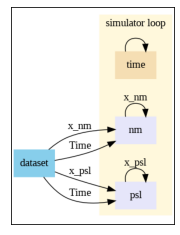

In [ ]:
sim_steps = 400
nm_system = sim.DynamicsNeuromancer(dynamics_model,
                name='nm', input_key_map={'x': 'x_nm', 'Time': 'Time'})
psl_system = sim.DynamicsPSL(modelSystem,
                name='psl', input_key_map={'x': 'x_psl', 'Time': 'Time'})
psl_system.model.ts = ts
components = [nm_system, psl_system]
system = sim.SystemSimulator(components)
system.plot_graph()

## Plot Open-Loop Trajectories

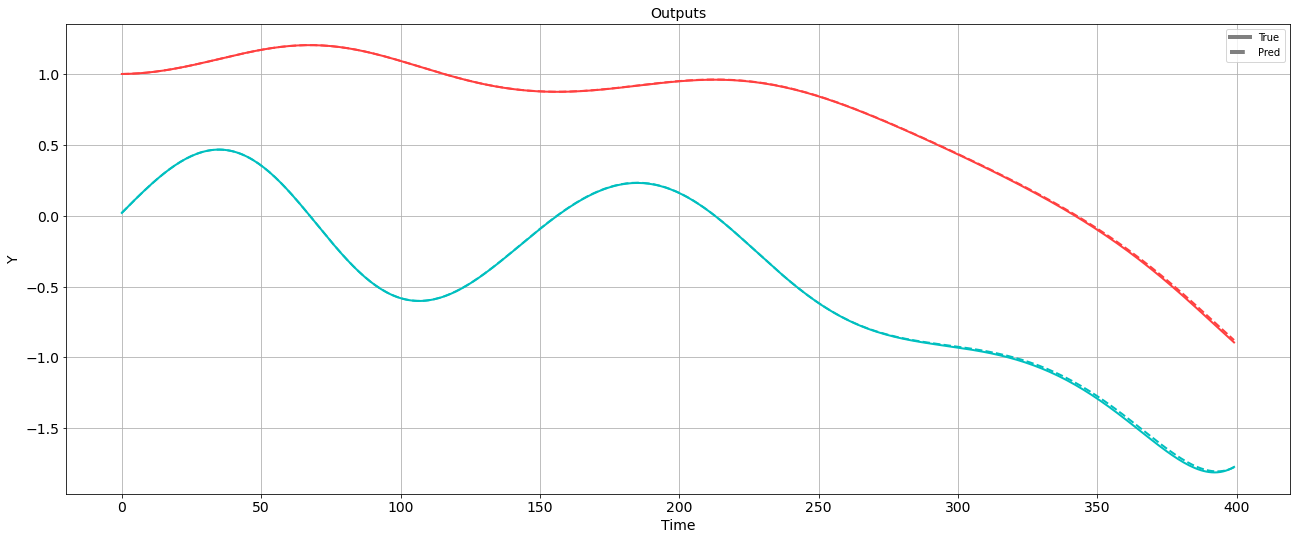

In [ ]:
x0 = np.asarray(modelSystem.x0)
data_init = {'x_psl': x0, 'x_nm': x0}
Time = raw['Time'][:sim_steps+1, :]
data_traj = {'Time': Time}
trajectories = system.simulate(nsim=sim_steps, data_init=data_init, data_traj=data_traj)
psl.plot.pltOL(Y=trajectories['y_psl'], Ytrain=trajectories['y_nm'])
fig = plt.gcf()
fig.set_size_inches(18,7)